In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader
import math
import numpy as np
from MixedStateTree import MixedStateTree, MixedStateTreeNode
from collections import deque
from jaxtyping import Float
from typing import Dict, Tuple, List, Optional, Iterable
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
# from generate_data import Mess3, ProcessDataset, process_dataset_collate_fn

In [3]:
class Process:
    def __init__(self, seq_length = 200, num_tokens = 3, num_states = 3):
        self.seq_length = seq_length
        self.transition_matrix, self.state_names = self._create_hmm()   # transition_matrix: (num_token, num_hidden_state, num_hidden_state)
        self.num_tokens = num_tokens
        self.num_states = num_states
        # self.num_tokens = self.transition_matrix.shape[0]
        # self.num_states = self.transition_matrix.shape[1]
        self.token2char = {0: "A", 1: "B", 2: "C", 3: "D"}

    def _create_hmm(self):   # create the transition matrix
        raise NotImplementedError("please implement _create_hmm in subclass")

    def steady_state_vector(self):
        state_transition_matrix = np.sum(self.transition_matrix, axis=0)

        eigenvalues, eigenvectors = np.linalg.eig(state_transition_matrix.T)
        steady_state_vector = eigenvectors[:, np.isclose(eigenvalues, 1)].real
        normalized_steady_state_vector = steady_state_vector / steady_state_vector.sum()
        out: np.ndarray = normalized_steady_state_vector[:, 0]

        assert out.ndim == 1
        assert len(out) == self.num_states
        return out

    def yield_emissions(self, sequence_len, current_state_idx: Optional[int] = None):
        if current_state_idx is None:
            current_state_idx = np.random.choice(self.num_states, p=self.steady_state_vector())
        for _ in range(sequence_len):
            emission, next_state_idx = self._sample_emission_and_next_state(current_state_idx)
            yield emission
            current_state_idx = next_state_idx

    def _sample_emission_and_next_state(self, current_state_idx):
        transition_probs = self.transition_matrix[:, current_state_idx, :]
        emission_next_state_idx = np.random.choice(transition_probs.size, p=transition_probs.ravel())
        emission = emission_next_state_idx // self.num_states
        next_state_idx = emission_next_state_idx % self.num_states
        return emission, next_state_idx

    def derive_mixed_state_presentation(self, depth: int) -> MixedStateTree:
        tree_root = MixedStateTreeNode(state_prob_vector=self.steady_state_vector(), children=set(), path=[],
                                       emission_prob=0)
        nodes = set([tree_root])

        stack = deque([(tree_root, self.steady_state_vector(), [], 0)])
        while stack:
            current_node, state_prob_vector, current_path, current_depth = stack.pop()
            if current_depth < depth:
                emission_probs = _compute_emission_probabilities(self, self.steady_state_vector())
                for emission in range(self.num_states):
                    if emission_probs[emission] > 0:
                        next_state_prob_vector = _compute_next_distribution(self.transition_matrix, state_prob_vector,
                                                                            emission)
                        child_path = current_path + [emission]
                        child_node = MixedStateTreeNode(state_prob_vector=next_state_prob_vector, path=child_path,
                                                        children=set(), emission_prob=emission_probs[emission])
                        current_node.add_child(child_node)

                        stack.append((child_node, next_state_prob_vector, child_path, current_depth + 1))
            nodes.add(current_node)

        return MixedStateTree(root_node=tree_root, process=self.name, nodes=nodes, depth=depth)

def _compute_emission_probabilities(
    hmm: Process,
    state_prob_vector: Float[np.ndarray, "num_states"]
) -> Float[np.ndarray, "vocab_len"]:
    """
    Compute the probabilities associated with each emission given the current mixed state.
    """
    T = hmm.transition_matrix
    emission_probs = np.einsum("s,esd->ed", state_prob_vector, T).sum(axis=1)
    emission_probs /= emission_probs.sum()
    return emission_probs

def _compute_next_distribution(
    epsilon_machine: Float[np.ndarray, "vocab_len num_states num_states"],
    current_state_prob_vector: Float[np.ndarray, "num_states"],
    current_emission: int
) -> Float[np.ndarray, "num_states"]:
    """
    Compute the next mixed state distribution for a given output.
    """
    X_next = np.einsum("sd, s -> d", epsilon_machine[current_emission], current_state_prob_vector)
    return X_next / np.sum(X_next) if np.sum(X_next) != 0 else X_next


class Mess3(Process):
    def __init__(self, seq_length = 200, num_tokens = 3, num_states = 3, x=0.05, a=0.85):
        self.name = "mess3"
        self.x = x
        self.a = a
        super().__init__(seq_length, num_tokens, num_states)

    def _create_hmm(self):
        T = np.zeros((3, 3, 3))
        state_names = {"A": 0, "B": 1, "C": 2}
        b = (1 - self.a) / 2
        y = 1 - 2 * self.x

        ay = self.a * y
        bx = b * self.x
        by = b * y
        ax = self.a * self.x

        T[0, :, :] = [[ay, bx, bx], [ax, by, bx], [ax, bx, by]]
        T[1, :, :] = [[by, ax, bx], [bx, ay, bx], [bx, ax, by]]
        T[2, :, :] = [[by, bx, ax], [bx, by, ax], [bx, bx, ay]]

        return T, state_names


class ProcessDataset(IterableDataset):
    # samples: Iterable[int]
    sequence_length: int
    num_samples: int

    def __init__(self, sequence_length: int, num_samples: int):
        super().__init__()
        self.process = Mess3()
        # self.samples = self.process.yield_emissions(
        #     sequence_len=num_samples * (sequence_length + 1)
        # )
        self.sequence_length = sequence_length
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __iter__(self) -> Iterable[Tuple[List[int]]]:
        samples = self.process.yield_emissions(
            sequence_len=self.num_samples * (self.sequence_length + 1)
        )
        for _ in range(self.num_samples):
            process_history = [
                next(samples) for _ in range(self.sequence_length + 1)
            ]
            yield (process_history[:-1], process_history[1:])


def process_dataset_collate_fn(batch: List[Tuple[List[int]]],):
    data = [x[0] for x in batch]
    labels = [x[1] for x in batch]
    return torch.tensor(data, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


def project_to_simplex(points: Float[np.ndarray, "num_points num_states"]):
    """Project points onto the 2-simplex (equilateral triangle in 2D)."""
    x = points[:, 1] + 0.5 * points[:, 2]
    y = (np.sqrt(3) / 2) * points[:, 2]
    return x, y

Path: 111221100, Belief: [0.88362626 0.09754951 0.01882424]
Path: 0110202100, Belief: [0.9573995  0.02416026 0.01844024]
Path: 0002112220, Belief: [0.40033219 0.03800703 0.56166078]
Path: 1112222202, Belief: [0.05921612 0.0122209  0.92856298]
Path: 011022011, Belief: [0.04541682 0.91658893 0.03799425]
Number of Unique beliefs: 83500 out of 88573
(0.48857, 0.24907, 0.26237) is indexed as 0
(0.43566, 0.05426, 0.51008) is indexed as 1
(0.06124, 0.92584, 0.01292) is indexed as 2
(0.10359, 0.01638, 0.88004) is indexed as 3
(0.03041, 0.58518, 0.38441) is indexed as 4


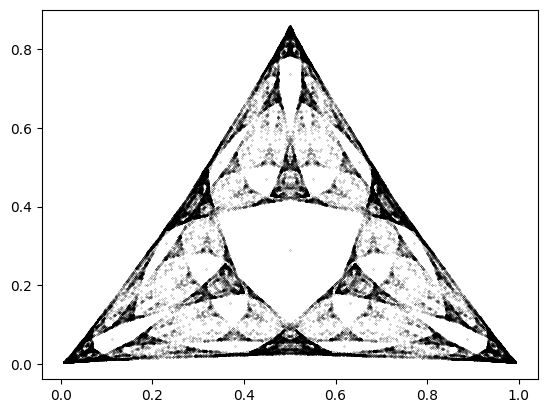

In [4]:
process = Mess3(x=0.05, a=0.85)    # x,a可以改，会改变data的结构，似乎越接近1分布越简单
mixed_state_tree = process.derive_mixed_state_presentation(depth=10)

tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
    print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

for i in range(5):
    ith_belief = list(msp_belief_index.keys())[i]
    print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")

from matplotlib import pyplot as plt
to_plot = list(msp_belief_index.keys())
x, y = project_to_simplex(np.array(to_plot))
plt.scatter(x, y, c='black', marker='.', s=.1)
plt.show()   # 到这里没有问题，完成了生成数据input，target，hidden state，并将hidden state画出来

In [5]:
# 这一块手动搭建transformer结构，下一块将用nn中已有的结构
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B, T, H)
        q = self.query(x)  # (B, T, H)
        wei = q @ torch.transpose(k, 1, 2) * C ** -0.5  # (B,T,T)
        wei = torch.tril(wei)
        wei = wei.masked_fill(wei == 0, float('-inf'))
        # print(wei.shape)
        wei = nn.functional.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ self.value(x)
        return out


class MultiHead(nn.Module):
    def __init__(self, num_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList(Head(head_size) for _ in range(num_head))
        self.proj = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.concatenate([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class Feedward(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.net(x)
        return x


class Block(nn.Module):
    def __init__(self, embed_size, n_head, block_id=None, cache=None):
        super().__init__()
        head_size = embed_size // n_head
        self.heads = MultiHead(n_head, head_size)
        self.fwd = Feedward()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)
        self.cache = cache
        self.block_id = block_id

    def forward(self, x):
        if self.cache is not None:
            self.cache[f'resid_pre_{self.block_id}'] = x.detach()
        x = x + self.heads(self.ln1(x))
        if self.cache is not None:
            self.cache[f'resid_mid_{self.block_id}'] = x.detach()
        x = x + self.fwd(self.ln2(x))
        if self.cache is not None:
            self.cache[f'resid_post_{self.block_id}'] = x.detach()
        return x


class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_tokens, embed_size)
        self.positional_embedding = nn.Embedding(seq_length, embed_size)
        # self.head = Head(head_size)
        self.blocks = nn.ModuleList([
            Block(embed_size, n_head, block_id=i) for i in range(n_layer)
        ])
        # self.blocks = nn.Sequential(
        #     nn.Sequential(*[Block(embed_size, n_head) for i in range(n_layer)]),
        #     nn.LayerNorm(embed_size),
        # )
        self.final_ln = nn.LayerNorm(embed_size)
        self.ll = nn.Linear(embed_size, num_tokens)


    def forward(self, x, target=None, cache = None):  # x, target:(B, T) (100, 200)
        B, T = x.shape
        tok_ebd = self.embedding(x)
        pos_ebd = self.positional_embedding(torch.arange(T))
        x = tok_ebd + pos_ebd

        for block in self.blocks:
            block.cache = cache  # 给每层传 cache
            x = block(x)

        x = self.final_ln(x)
        if cache is not None:
            cache['resid_final'] = x.detach()

        x = self.ll(x)  # x:(B, T, C) (100, 200, 3)
        # print(target.shape)



        if target is not None:
            loss = nn.functional.cross_entropy(x.reshape([-1, num_tokens]), target.reshape([-1]))

            preds = x.argmax(dim=-1)  # [B, T-1]
            correct = (preds == target).sum().item()
            total = target.numel()
            acc = correct / total
        else:
            loss = None
            acc = None
        return x, loss, acc # (B, T, C), ()

    def run_with_cache(self, x, names_filter=lambda name: True):
        """
        运行前向传播并缓存中间值。返回：logits, cache 字典
        """
        cache = {}
        with torch.no_grad():
            logits, _, _ = self.forward(x, target=None, cache=cache)

        filtered_cache = {k: v for k, v in cache.items() if names_filter(k)}
        return logits, filtered_cache

    def generate(self, x, max_len_gene):
        for i in range(max_len_gene):
            idx_cond = x[:, -seq_length:]
            new_logit, _ = self(idx_cond) # (B,C)
            prob = nn.functional.softmax(new_logit[:,-1,:], dim=-1)     #(B, C)
            new_index = torch.multinomial(prob, 1)      #(B, 1)
            x = torch.concatenate([x, new_index], dim=1)
        return x

In [6]:
# 这个cell用nn中自带的TransformerEncoderLayer来实现
# Todo: 1. 训练效果也不好，loss不降
#       2. 没有测试集
#       3. 记录每层的residual stream，即实现上一块中的cache
#       4. 如果改用transformer_lens 中的 HookedTransformer 可以很轻松实现3，但我的环境有问题没装好

class TransformerLM(nn.Module):
    def __init__(self, num_tokens, embed_size, n_head, n_layer, dropout=0.1):
        super().__init__()
        self.token_embed = nn.Embedding(num_tokens, embed_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size,
            nhead=n_head,
            dim_feedforward=embed_size * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layer)
        self.output_head = nn.Linear(embed_size, num_tokens)

    def forward(self, x):
        cache = {}
        # x: [batch_size, seq_length]
        x = self.token_embed(x)                     # [B, T, E]
        x = self.transformer(x)                     # [B, T, E]
        logits = self.output_head(x)                # [B, T, num_tokens]
        return logits

In [7]:
def train():
    
    for i in range(epoch):
        for xi, yi in dataloader:
            logits, loss, acc = net(xi, yi)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
        if i % print_every == 0:

            # for name, value in cache.items():
            #     print(name, value.shape)

            # esti_loss = estimate_loss()
            # print(f"epoch:{i}, train loss:{esti_loss['train']}, test loss: {esti_loss['test']}")
            print(f"epoch:{i}, train loss:{loss}, accuracy:{acc}")


if __name__ == "__main__":

    is_train = True
    seq_length = 4
    num_tokens = 3
    num_states = 3
    batch_size = 100
    num_samples = 20000
    process = Mess3(seq_length, num_tokens, num_states, x=0.05, a=0.85)
    dropout = 0.0
    embed_size = 5
    n_head = 1
    n_layer = 4
    epoch = 10
    lr = 0.03
    print_every = 1
    test_split = 1  # ？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？
    
    dataset = ProcessDataset(
        sequence_length=seq_length,
        num_samples=(
            num_samples
            if is_train
            else math.floor(num_tokens * test_split)
        ),
    )

    dataloader = DataLoader(
        dataset=dataset,
        collate_fn=process_dataset_collate_fn,
        batch_size=batch_size,
    )

    net = Transformer()
    # net = TransformerLM(num_tokens, embed_size, n_head, n_layer, dropout)
    optimizer = torch.optim.AdamW(net.parameters(), lr)
    
    train()

    

epoch:0, train loss:0.7673784494400024, accuracy:0.7175
epoch:1, train loss:0.9051530361175537, accuracy:0.625
epoch:2, train loss:0.7639489769935608, accuracy:0.7225
epoch:3, train loss:0.8409569263458252, accuracy:0.6625
epoch:4, train loss:0.825310468673706, accuracy:0.685
epoch:5, train loss:0.7740074396133423, accuracy:0.695
epoch:6, train loss:0.8592395186424255, accuracy:0.65
epoch:7, train loss:0.7951828241348267, accuracy:0.6975
epoch:8, train loss:0.7442741990089417, accuracy:0.735
epoch:9, train loss:0.8222973346710205, accuracy:0.675


In [8]:
from transformer_lens import HookedTransformer, HookedTransformerConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seq_length = 4
num_tokens = 3
num_states = 3
batch_size = 100
num_samples = 20000
embed_size = 5     # This defines the model (hidden) size, i.e. num_model in the hook outputs.
n_head = 1
n_layer = 4
num_epochs = 1
lr = 0.03
print_every = 1

config = HookedTransformerConfig(
    d_model=embed_size,            
    n_layers=n_layer,              
    n_heads=n_head,                
    d_head=embed_size // n_head,   
    d_vocab=num_tokens,            
    d_mlp=4 * embed_size,          # feedforward (MLP) dimension
    act_fn="gelu",                 # activation function
    n_ctx=seq_length
)


model = HookedTransformer(config)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print("Starting training...")
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        # Assume the dataloader returns a tuple (inputs, targets)
        inputs, targets = batch  # shapes: (batch_size, seq_length)
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # Forward pass: model returns logits of shape (batch_size, seq_length, num_tokens)
        logits = model(inputs)
        
        # Reshape for computing loss: flatten batch and sequence dimensions
        loss = criterion(logits.view(-1, num_tokens), targets.view(-1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    if (epoch + 1) % print_every == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete.")

residual_acts = {}

# Define a hook function factory to capture activations.
def get_hook(name):
    def hook(act, hook):
        # Save the activation (detach to remove from computation graph)
        residual_acts[name] = act.detach().cpu()
    return hook

# Create hook names for each layer. Typically, in HookedTransformer, the output after each block’s
# residual addition is stored in "blocks.{layer_number}.resid_post".
hook_names = [f"blocks.{i}.hook_resid_post" for i in range(n_layer)]

# Now get one sample batch to run inference with hooks.
sample_inputs, _ = next(iter(dataloader))

# Run the model with hooks to capture activations.
# run_with_hooks returns (final_output, dict_of_activations)
final_output, _ = model.run_with_hooks(
    sample_inputs,
    fwd_hooks=[(hook_name, get_hook(hook_name)) for hook_name in hook_names],
    return_type="both",  # returns both final output and the activations dictionary
)

# Now each key in residual_acts contains the residual stream activations with shape (batch_size, seq_length, embed_size)
for name, act in residual_acts.items():
    print(f"Residual stream activation from {name} has shape: {act.shape}")

/home/yuxuan/anaconda3/envs/news/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Moving model to device:  cuda
Starting training...
Epoch [1/1], Loss: 0.8549
Training complete.
Residual stream activation from blocks.0.hook_resid_post has shape: torch.Size([100, 4, 5])
Residual stream activation from blocks.1.hook_resid_post has shape: torch.Size([100, 4, 5])
Residual stream activation from blocks.2.hook_resid_post has shape: torch.Size([100, 4, 5])
Residual stream activation from blocks.3.hook_resid_post has shape: torch.Size([100, 4, 5])


(20000, 3)


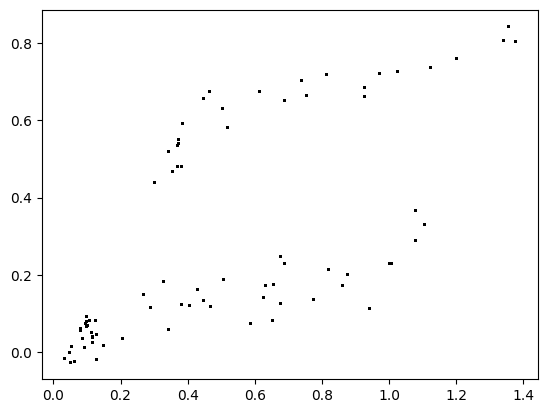

In [13]:
# 取transformer中的residual stream，看他是否包含了hidden state信息
# Todo：画出来的图和ground truth毫不相关
# 可能有用的信息：
# 怎样算包含了hidden state信息：residual 经过一个线性变化可以得到hidden state
# 作者的关于网络结构interpretable的一个idea：取每层的residual，看它经过linear regression是否可以得到hidden state，在哪一层linear regression的loss小，我们就认为这一层学到了（这应该是nn interpretable的一种常用思路）
def get_beliefs_for_transformer_inputs(
        transformer_inputs: Float[torch.Tensor, "batch n_ctx"],
        msp_belief_index: Dict[Tuple[float, ...], int],
        tree_paths: List[List[int]],
        tree_beliefs: List[List[float]]
) -> Tuple[Float[torch.Tensor, "batch n_ctx belief_dim"], Float[torch.Tensor, "batch n_ctx"]]:

    batch, n_ctx = transformer_inputs.shape
    belief_dim = len(list(msp_belief_index.keys())[0])
    path_belief_dict = {tuple(path): belief for path, belief in zip(tree_paths, tree_beliefs)}
    X_beliefs = torch.zeros(batch, n_ctx, belief_dim, device=transformer_inputs.device)
    X_belief_indices = torch.zeros(batch, n_ctx, dtype=torch.int, device=transformer_inputs.device)

    for i in range(batch):
        for j in range(n_ctx):
            input_substring = transformer_inputs[i, :j + 1].cpu().numpy()
            belief_state = path_belief_dict[tuple(input_substring)]
            belief_state = np.round(belief_state, 5)
            X_beliefs[i, j] = torch.tensor(belief_state, dtype=torch.float32, device=transformer_inputs.device)
            X_belief_indices[i, j] = msp_belief_index[tuple(belief_state)]

    return X_beliefs, X_belief_indices


def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):
    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model)  # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim)  # [batch * n_ctx, belief_dim]

    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened)  # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions

msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

for inputs, _ in DataLoader(
    dataset=dataset,
    collate_fn=process_dataset_collate_fn,
    batch_size=20000,
):
    _, activations = net.run_with_cache(inputs, names_filter=lambda name: 'resid' in name)
    acts = activations['resid_post_0']
    transformer_input_beliefs, transformer_input_beliefs_index = get_beliefs_for_transformer_inputs(inputs,
                                                                                                    msp_belief_index,
                                                                                                    tree_paths,
                                                                                                    tree_beliefs)

    regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)

    x, y = project_to_simplex(np.array(belief_predictions))
    print(x.shape)
    plt.scatter(x, y, c='black', marker='.', s=.1)
    plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# For reproducibility
torch.manual_seed(42)

# Suppose these are your data tensors of shape (num_sample, seq_length, num_token)
# Replace the random data below with your actual acts and ground_truth_belief tensors.
num_sample = 20000  # For example, 20,000 samples
seq_length = 4
num_token = 5

# Example dummy data; in practice, you would use your actual data.
acts = residual_acts["blocks.3.hook_resid_post"]
ground_truth_belief = transformer_input_beliefs

# Flatten the sample and sequence dimensions.
# New shape: (num_sample * seq_length, num_token)
X = acts.view(400, -1)
y = ground_truth_belief.view(-1, num_token)

# Define a linear regression model: maps an input of size num_token to an output of size num_token.
model = nn.Linear(num_token, num_token)

# Mean Squared Error loss for regression.
criterion = nn.MSELoss()

# Adam optimizer
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Hyperparameters for training
num_epochs = 100
batch_size = 128

# Determine the number of batches per epoch.
num_samples_total = X.shape[0]
num_batches = num_samples_total // batch_size

# Training loop
for epoch in range(num_epochs):
    permutation = torch.randperm(num_samples_total)
    epoch_loss = 0.0
    
    for i in range(0, num_samples_total, batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X[indices], y[indices]
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass: predict the belief from acts.
        outputs = model(batch_X)
        
        # Compute loss between predicted and ground truth belief.
        loss = criterion(outputs, batch_y)
        
        # Backpropagation and optimization step.
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / num_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete.")

# Example prediction: computing the predicted ground truth belief for the training data.
predicted_belief = model(X)
print("Predicted belief shape:", predicted_belief.shape)


Epoch [1/100], Loss: 19.8164
Epoch [2/100], Loss: 11.3534
Epoch [3/100], Loss: 6.6980
Epoch [4/100], Loss: 3.8904
Epoch [5/100], Loss: 2.4561
Epoch [6/100], Loss: 1.6767
Epoch [7/100], Loss: 0.9730
Epoch [8/100], Loss: 0.6909
Epoch [9/100], Loss: 0.6255
Epoch [10/100], Loss: 0.5725
Epoch [11/100], Loss: 0.6587
Epoch [12/100], Loss: 0.5498
Epoch [13/100], Loss: 0.5813
Epoch [14/100], Loss: 0.5099
Epoch [15/100], Loss: 0.4853
Epoch [16/100], Loss: 0.4178
Epoch [17/100], Loss: 0.4101
Epoch [18/100], Loss: 0.4256
Epoch [19/100], Loss: 0.3936
Epoch [20/100], Loss: 0.3772
Epoch [21/100], Loss: 0.3685
Epoch [22/100], Loss: 0.3973
Epoch [23/100], Loss: 0.3542
Epoch [24/100], Loss: 0.3209
Epoch [25/100], Loss: 0.3501
Epoch [26/100], Loss: 0.3486
Epoch [27/100], Loss: 0.3216
Epoch [28/100], Loss: 0.3233
Epoch [29/100], Loss: 0.3361
Epoch [30/100], Loss: 0.3271
Epoch [31/100], Loss: 0.3394
Epoch [32/100], Loss: 0.3070
Epoch [33/100], Loss: 0.3235
Epoch [34/100], Loss: 0.2813
Epoch [35/100], Loss: